In [130]:
from functions import *
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_smooth,
    labs, xlab, element_blank
)
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm

In [5]:
data_ml = load_data()

<Axes: >

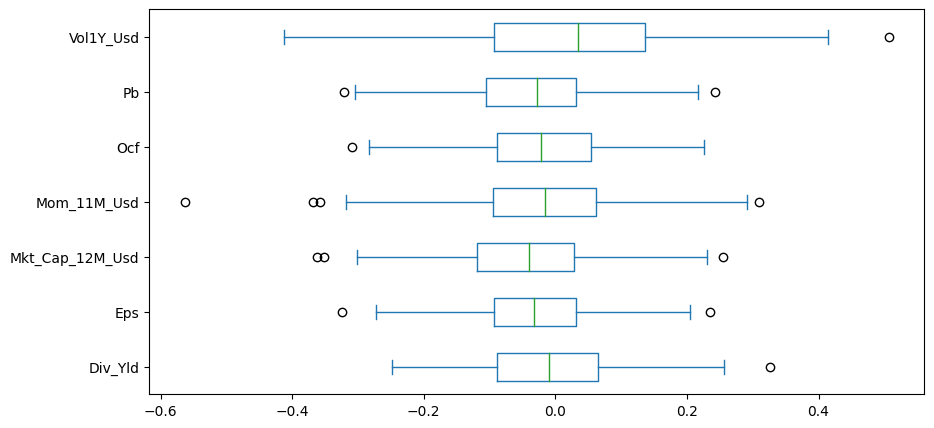

In [6]:
# use boxplot to exam summary statistics
# here we check the correlation between features and return
df = data_ml.loc[:,["date","R1M_Usd"]+features_short]
df.groupby("date").apply(lambda df: df[features_short].corrwith(df["R1M_Usd"])).plot(kind="box", vert=False)

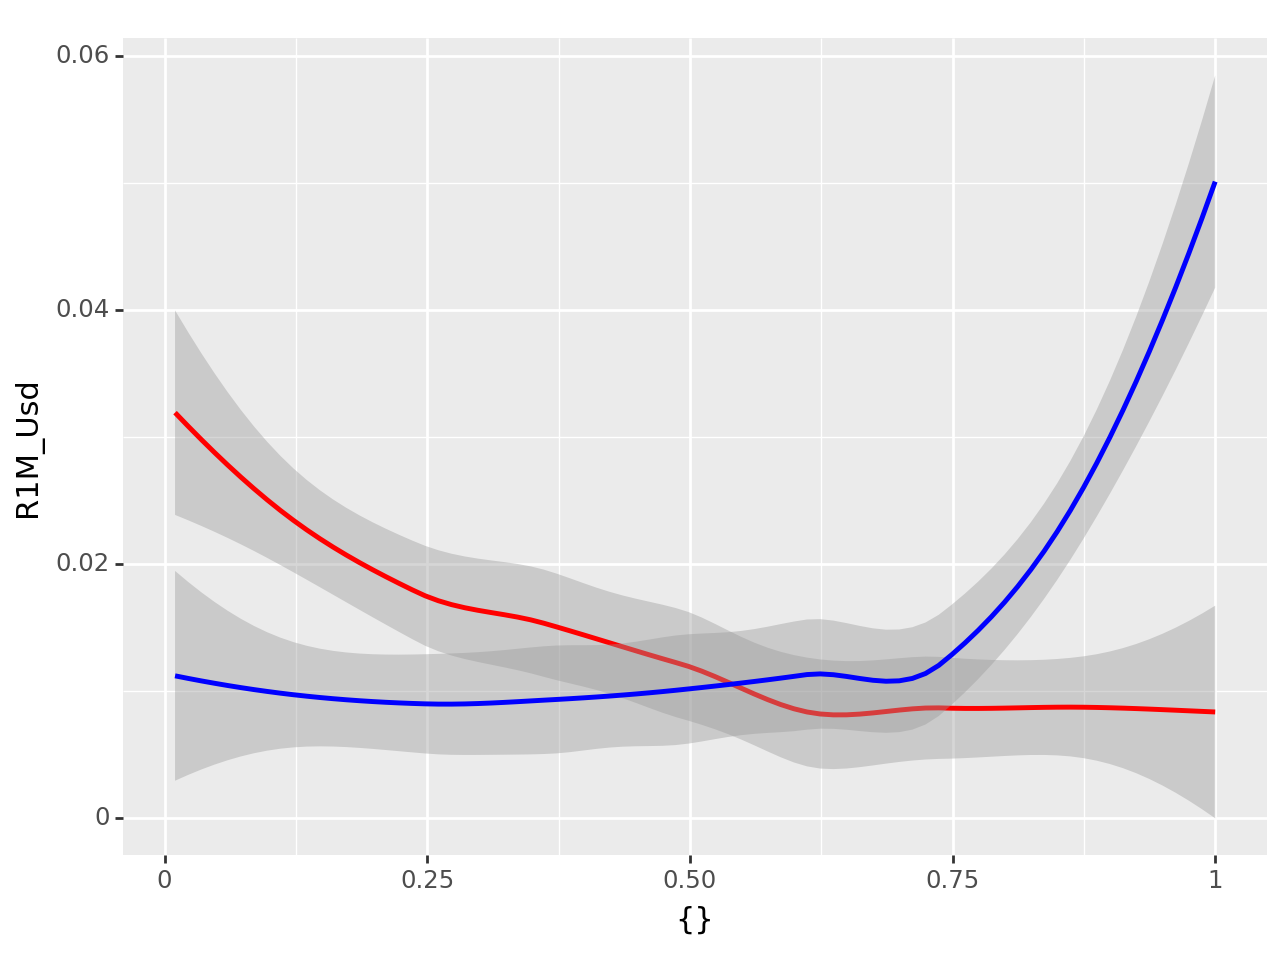

<Figure Size: (640 x 480)>

In [25]:
# the correlation between the predictors and the return can also be seen by ploting the conditional average E(Y|X=x)
# it's too slow to run the full data set on my comuputer so I just take 10% randomly
reduced_data = data_ml.iloc[np.random.choice(data_ml.shape[0], 20000),:]
(ggplot(reduced_data, aes(y='R1M_Usd')) + geom_smooth(aes(x="Mkt_Cap_12M_Usd"), method="loess", color="red") 
+ geom_smooth(aes(x="Vol1Y_Usd"), method="loess", color="blue") + labs(color="Predictor") +xlab(element_blank())
                                                                                                )
# didn't figure out how to add

In [30]:
#exam the autocorrelations of each feature
features = data_ml.columns.to_list()[3:95]
df = data_ml.loc[:,["stock_id"]+features]

In [35]:
def acf(x, leg=1):
    return np.corrcoef(x[:-leg], x[leg:])[0,1]

acfs = df.groupby("stock_id").aggregate(acf).values.flatten()

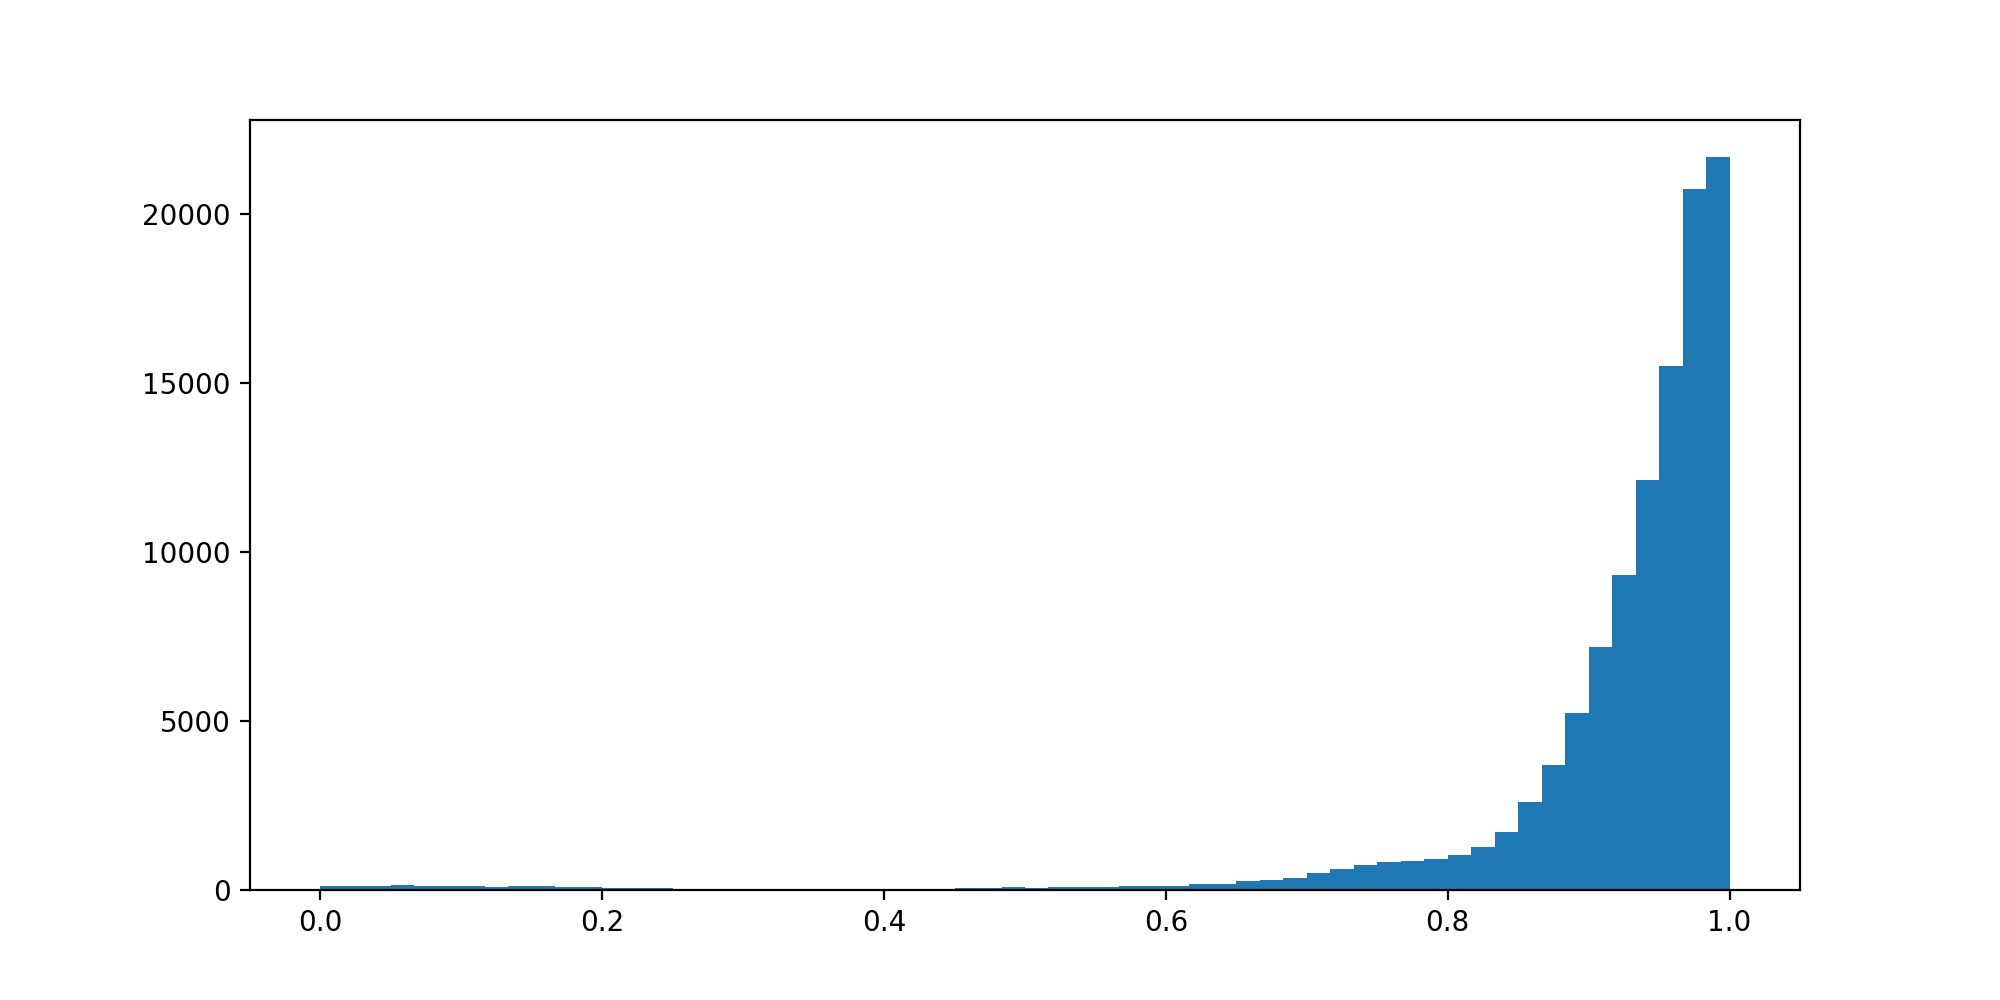

In [44]:
ax = plt.hist(acfs, bins=60, range=(0,1))

<BarContainer object of 100 artists>

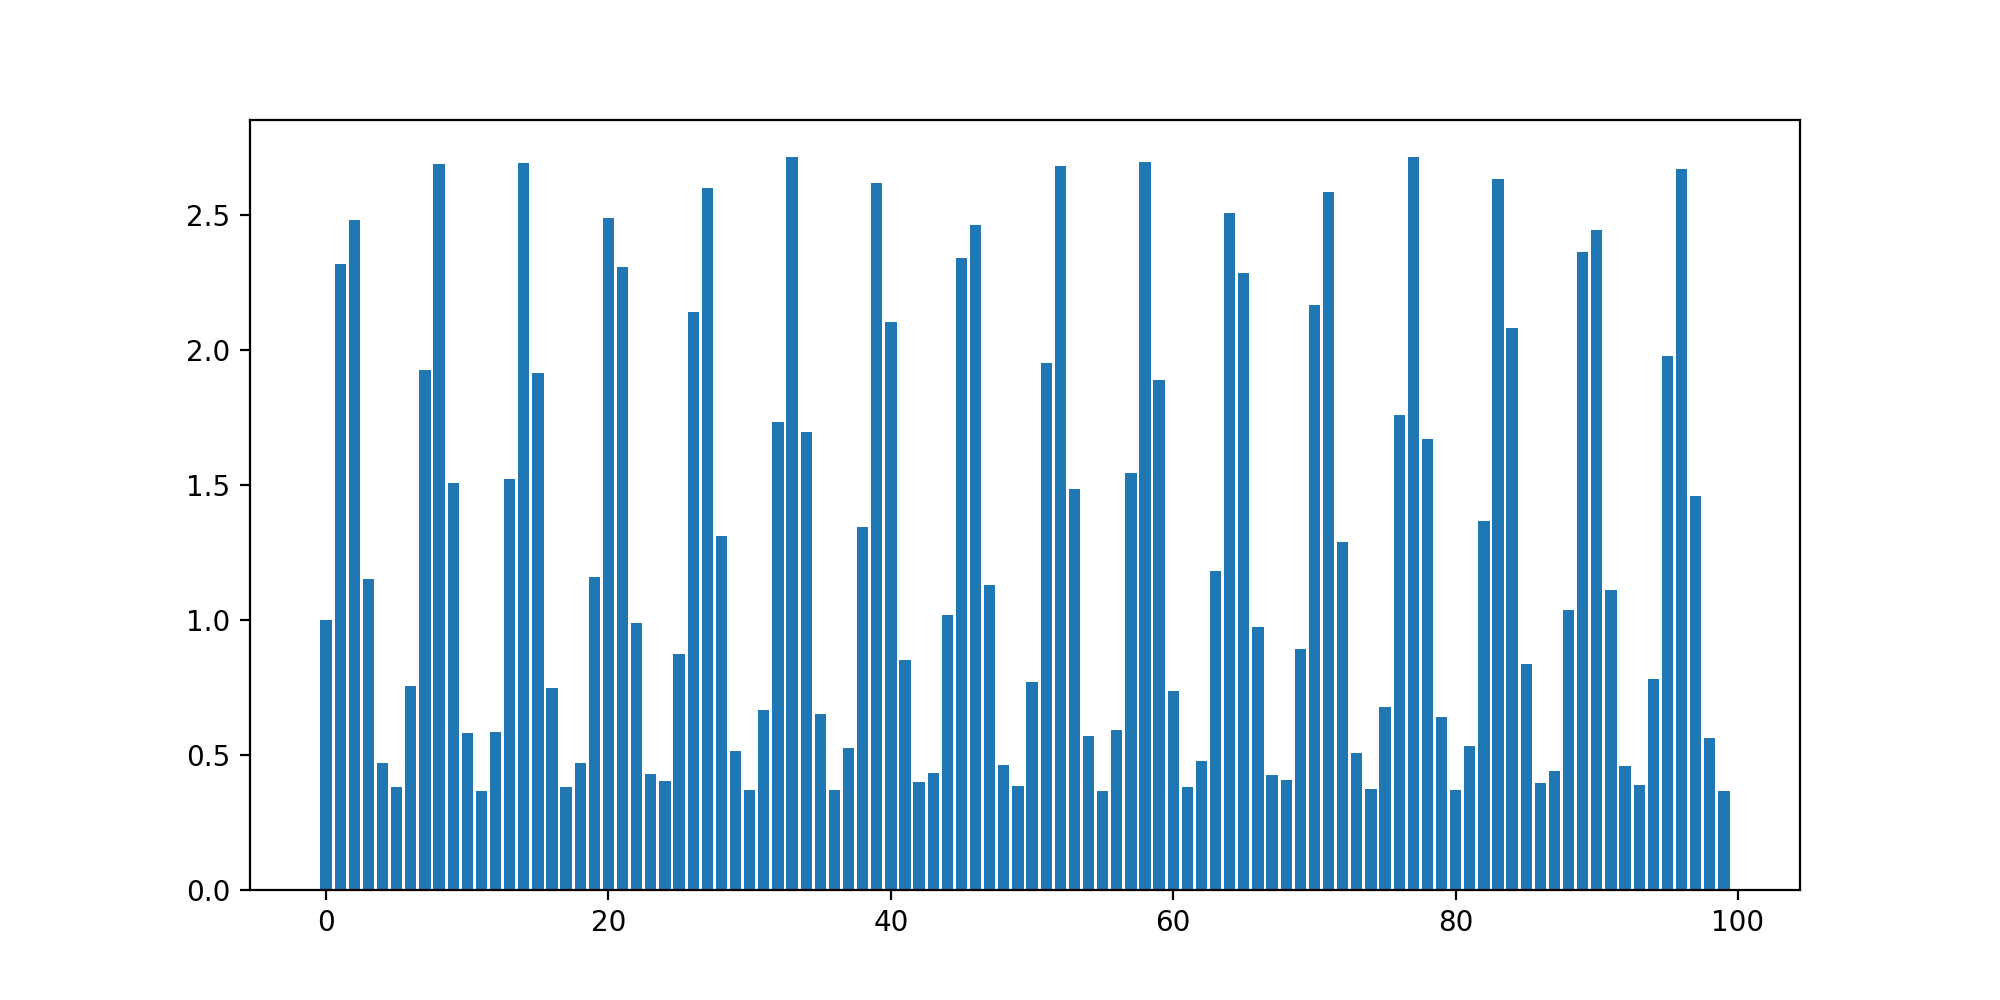

In [48]:
# To study the impact of rescaling, we consider the following abitrary data
index = np.array(range(100))
x = np.exp(np.sin(index))
plt.bar(index,height=x)

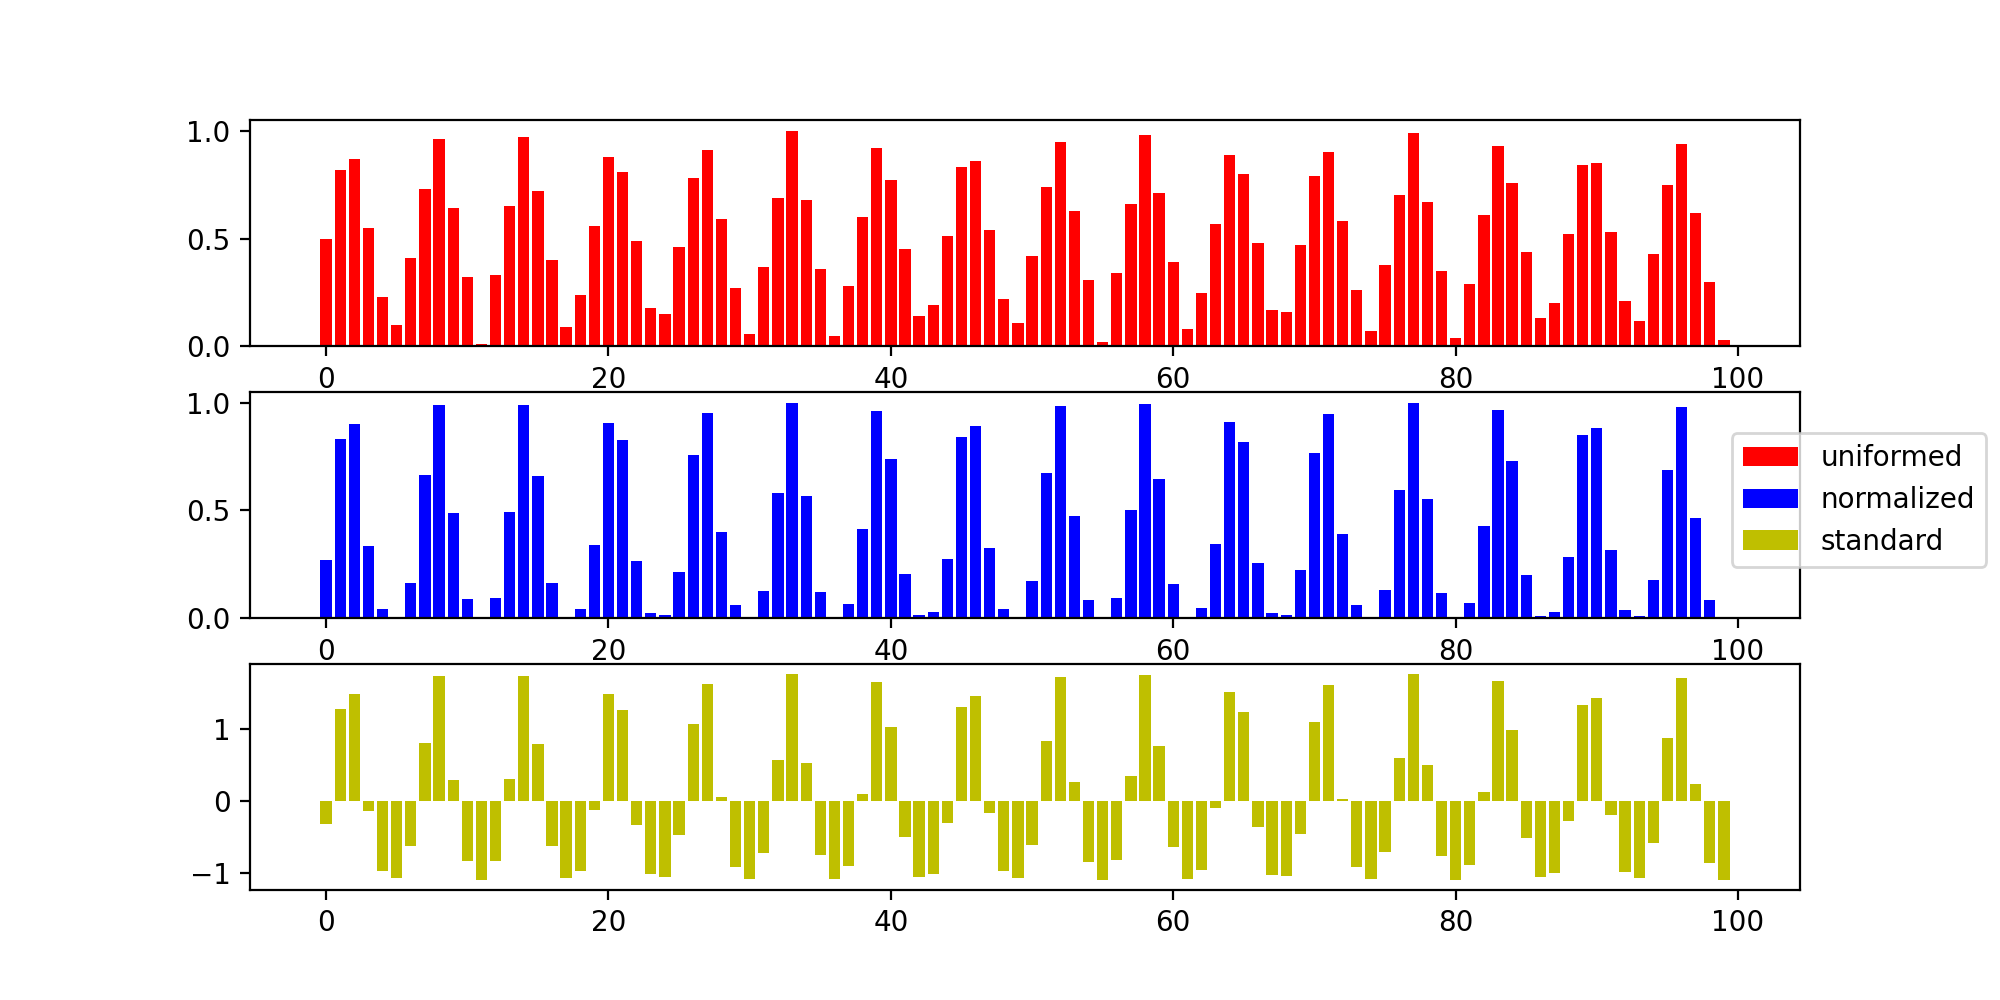

In [62]:
# we rescale the data in three ways
#1. uniformize
x_unif = ECDF(x)(x)
#2 renormalize it between 0 and 1
x_norm_0_1 = (x - min(x)) / (max(x)-min(x))
x_std = (x - np.mean(x))/np.std(x)

fig, ax = plt.subplots(3,1, figsize=[10,5])
p1 = ax[0].bar(index,height=x_unif, color='r')

p2 = ax[1].bar(index,height=x_norm_0_1, color='b')

p3 = ax[2].bar(index,height=x_std, color="y")

fig.legend([p1,p2,p3], labels=["uniformed", "normalized", "standard"],loc='right')
plt.show()


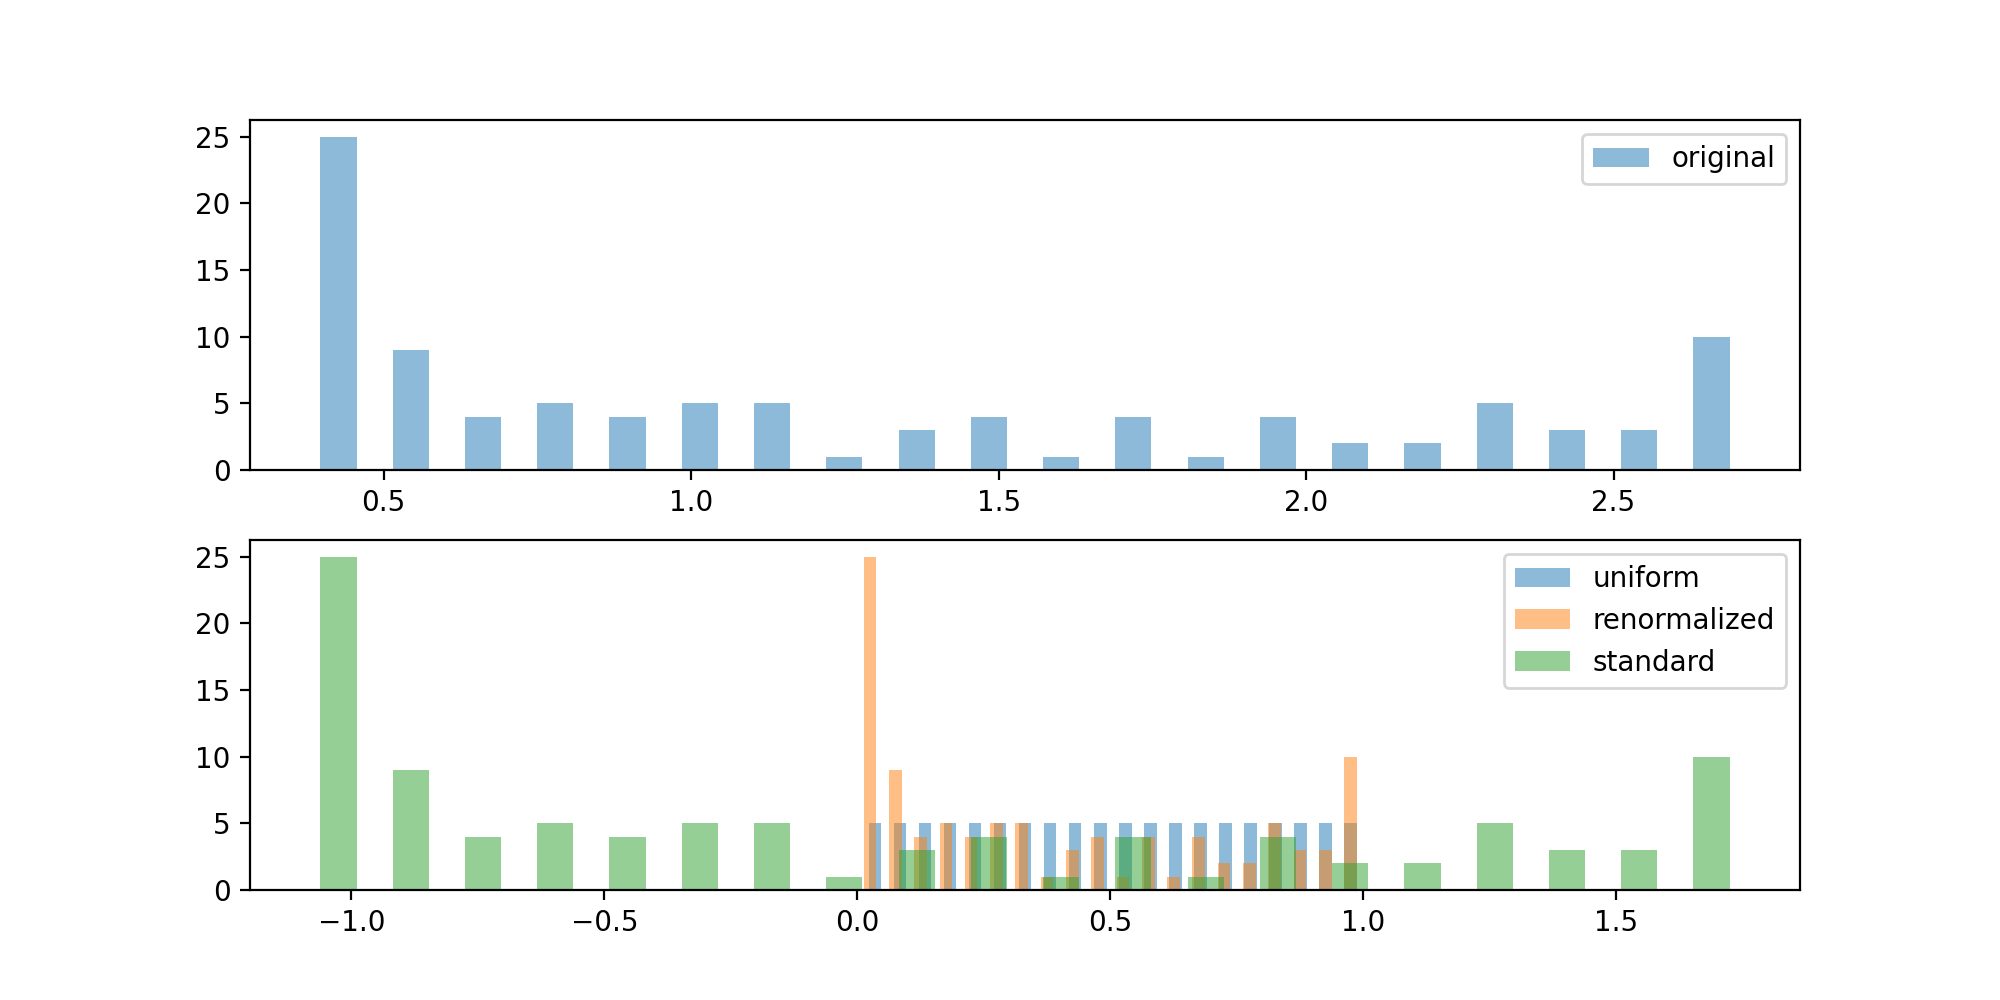

In [86]:
# we can also compare the histgram
fig, ax = plt.subplots(2,1)
ax[0].hist(x, bins=20, alpha=0.5, rwidth=0.5, label="original")
ax[0].legend()

ax[1].hist(x_unif, bins=20, alpha=0.5, rwidth=0.5, label = "uniform")
ax[1].hist(x_norm_0_1, bins=20, alpha=0.5, rwidth=0.5, label = "renormalized")
ax[1].hist(x_std, bins=20, alpha=0.5, rwidth=0.5, label="standard")
ax[1].legend()

As can be seen the distribution does not change for renormalization and standardlization.

In [117]:
# next we study the impact of rescaling by considering a toy example
firm = [1]*3 +[2]*3 + [3]*3
date = [1,2,3]*3
cap = [10,50,100,15,10,15,200,120,80]
ret= [0.06,0.01,-0.06,-0.03,0,0.02,-0.04,-0.02,0]
data_toy = pd.DataFrame({"firm": firm, "date":date, "cap":cap, "ret":ret})
data_toy

,firm,date,cap,ret
0,1,1,10,0.06
1,1,2,50,0.01
2,1,3,100,-0.06
3,2,1,15,-0.03
4,2,2,10,0.00
5,2,3,15,0.02
6,3,1,200,-0.04
7,3,2,120,-0.02
8,3,3,80,0.00


In [120]:
# we rescale the cap data for each date
data_toy["cap_0_1"] = data_toy.groupby("date")["cap"].transform(lambda x: (x - min(x)) / (max(x)-min(x)))
data_toy["cap_unif"] = data_toy.groupby("date")["cap"].transform(lambda x: ECDF(x)(x))
data_toy["cap_std"] = data_toy.groupby("date")["cap"].transform(lambda x: (x - np.mean(x))/np.std(x))
data_toy

,firm,date,cap,ret,cap_0_1,cap_unif,cap_std
0,1,1,10,0.06,0.000000,0.333333,-0.735195
1,1,2,50,0.01,0.363636,0.666667,-0.219971
2,1,3,100,-0.06,1.000000,1.000000,0.964562
3,2,1,15,-0.03,0.026316,0.666667,-0.678642
4,2,2,10,0.00,0.000000,0.333333,-1.099853
5,2,3,15,0.02,0.000000,0.333333,-1.377946
6,3,1,200,-0.04,1.000000,1.000000,1.413837
7,3,2,120,-0.02,1.000000,1.000000,1.319824
8,3,3,80,0.00,0.764706,0.666667,0.413384


In [155]:
x_ls = ["cap", "cap_0_1","cap_unif","cap_std"]
def  get_res(x):
    X = data_toy[x]
    X2 = sm.add_constant(X)
    y = data_toy["ret"]
    res = sm.OLS(y, X2).fit()
    return res.params.values, [res.pvalues[i] for i in range(X2.shape[1])]


df_coef = pd.DataFrame({x: get_res(x)[0] for x in x_ls}, index=["beta0","beta1"])
df_pv = pd.DataFrame({x: get_res(x)[1] for x in x_ls}, index=["p0","p1"])
print(df_coef)
print(df_pv)

            cap   cap_0_1  cap_unif   cap_std
beta0  0.015817  0.016278      0.06 -0.006667
beta1 -0.000337 -0.049703     -0.10 -0.021593
         cap   cap_0_1  cap_unif   cap_std
p0  0.320759  0.274639  0.019164  0.516617
p1  0.077775  0.052942  0.008351  0.062621


As we can see, the models used unscaled feature almost fails to capture the negative relation between the cap and the return. 